In [ ]:
import numpy as np
import pickle
import time
from sklearn.metrics import roc_curve, auc, f1_score, recall_score, precision_score, mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras import layers, models, Input
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, f1_score, recall_score, precision_score, accuracy_score
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Training/validation on 32450 samples and testing on 3894 samples.
Epoch 1/5
902/902 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - loss: 1098.2913 - val_loss: 730.9729
Epoch 2/5
902/902 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 629.9473 - val_loss: 262.6584
Epoch 3/5
902/902 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 268.5437 - val_loss: 165.0888
Epoch 4/5
902/902 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 186.5184 - val_loss: 144.9885
Epoch 5/5
902/902 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 162.4315 - val_loss: 139.5880
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test MSE for VAE: 0.0384


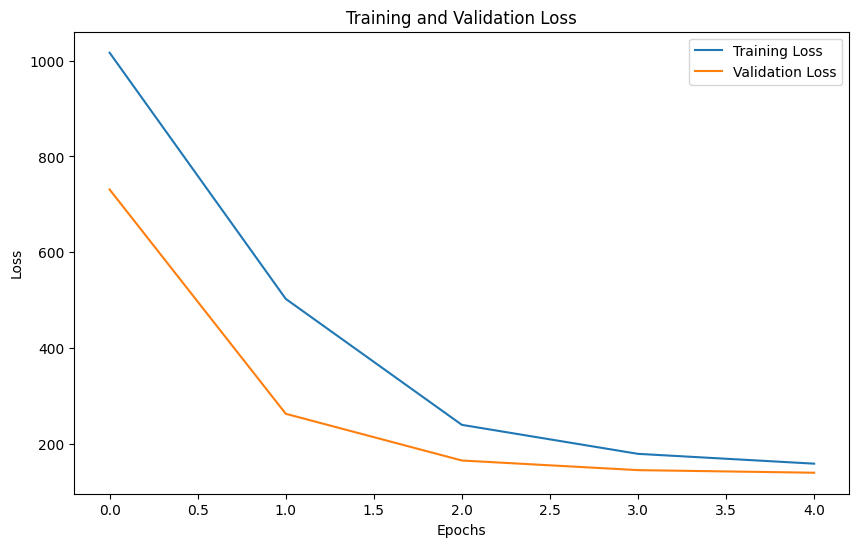

VAE Evaluation Metrics on Test Data:
MSE: 0.0384
RMSE: 0.1960
R-squared (R2): -0.0195
MAE: 0.0923
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
VAE Evaluation Metrics on Validation Data:
MSE: 0.0304
RMSE: 0.1743
R-squared (R2): -0.0622
MAE: 0.0848


In [3]:
import numpy as np
import pickle
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.losses import mse
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Loading data
with open('/content/drive/MyDrive/Colab Notebooks/Thesis/data/ccl_complete_data_28CCL_1298DepOI_36344samples_demo.pickle', 'rb') as f:
    data_mut, data_exp, data_cna, data_meth, data_dep, data_fprint = pickle.load(f)

# Defining Sampling Layer
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Encoder
def build_encoder(input_dim, latent_dim):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(64, activation='relu', kernel_regularizer=l2(0.01))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(30, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
    z = Sampling()([z_mean, z_log_var])
    model = models.Model(inputs, [z_mean, z_log_var, z], name='encoder')
    return model

# Decoder
def build_decoder(latent_dim, original_dim):
    latent_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(34, activation='relu', kernel_regularizer=l2(0.01))(latent_inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(60, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(original_dim, activation='sigmoid')(x)
    model = models.Model(latent_inputs, outputs, name='decoder')
    return model

# VAE model
class VAELoss(layers.Layer):
    def call(self, inputs):
        x, z_mean, z_log_var, reconstructed = inputs
        reconstruction_loss = mse(x, reconstructed)
        reconstruction_loss *= original_dim
        kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= -0.5
        total_loss = K.mean(reconstruction_loss + 0.1 * kl_loss)  
        self.add_loss(total_loss)
        return reconstructed

def build_vae(encoder, decoder, input_dim):
    inputs = layers.Input(shape=(input_dim,))
    z_mean, z_log_var, z = encoder(inputs)
    reconstructed = decoder(z)
    outputs = VAELoss()([inputs, z_mean, z_log_var, reconstructed])
    model = models.Model(inputs, outputs, name='vae')
    return model

# Setting parameters 
original_dim = data_mut.shape[1]
latent_dim = 20  # Reduced latent dimension

encoder = build_encoder(original_dim, latent_dim)
decoder = build_decoder(latent_dim, original_dim)

# compiling VAE
vae = build_vae(encoder, decoder, input_dim=original_dim)
optimizer = Adam(learning_rate=0.0001)
vae.compile(optimizer=optimizer)

# Splitting data into train/validation and test sets
num_DepOI = 1298
num_ccl = int(data_mut.shape[0] / num_DepOI)
id_rand = np.random.permutation(num_ccl)
id_cell_train = id_rand[np.arange(0, round(num_ccl * 0.9))]
id_cell_test = id_rand[np.arange(round(num_ccl * 0.9), num_ccl)]

id_train = np.arange(0, 1298) + id_cell_train[0] * 1298
for y in id_cell_train:
    id_train = np.union1d(id_train, np.arange(0, 1298) + y * 1298)

id_test = np.arange(0, 1298) + id_cell_test[0] * 1298
for y in id_cell_test:
    id_test = np.union1d(id_test, np.arange(0, 1298) + y * 1298)

print(f"Training/validation on {len(id_train)} samples and testing on {len(id_test)} samples.")

# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

# Training the VAE
history = vae.fit(
    data_mut[id_train], data_mut[id_train],
    epochs=5,
    batch_size=32,
    validation_split=1/9,
    shuffle=True,
    verbose=1,
    callbacks=[early_stopping]
)

encoded_data = encoder.predict(data_mut[id_test])[2]
decoded_data = decoder.predict(encoded_data)

# Evaluating on the test set
mse_test = mse(data_mut[id_test], decoded_data)
print(f"Test MSE for VAE: {np.mean(mse_test):.4f}")

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluation metrics
decoded_data_flat = decoded_data.flatten()
mse = mean_squared_error(data_mut[id_test].flatten(), decoded_data_flat)
rmse = np.sqrt(mse)
r2 = r2_score(data_mut[id_test].flatten(), decoded_data_flat)
mae = mean_absolute_error(data_mut[id_test].flatten(), decoded_data_flat)

print(f"VAE Evaluation Metrics on Test Data:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R-squared (R2): {r2:.4f}")
print(f"MAE: {mae:.4f}")


val_data = data_mut[id_train[int((8/9) * len(id_train)):]]  

encoded_val_data = encoder.predict(val_data)[2]
decoded_val_data = decoder.predict(encoded_val_data)

# Evaluating on the validation set
mse_val = mean_squared_error(val_data.flatten(), decoded_val_data.flatten())
rmse_val = np.sqrt(mse_val)
r2_val = r2_score(val_data.flatten(), decoded_val_data.flatten())
mae_val = mean_absolute_error(val_data.flatten(), decoded_val_data.flatten())

# Printing validation metrics
print(f"VAE Evaluation Metrics on Validation Data:")
print(f"MSE: {mse_val:.4f}")
print(f"RMSE: {rmse_val:.4f}")
print(f"R-squared (R2): {r2_val:.4f}")
print(f"MAE: {mae_val:.4f}")